# 0. Download models from DataShare

In [5]:
try:
    import wget
except ImportError:
    !pip install wget
    import wget
import os

if not os.path.exists('sandbox'):
    os.makedirs('sandbox')

model_url = 'https://datashare.biochem.mpg.de/s/my3mXocIH9p1Y91/download'
zip_path = 'sandbox/models.zip'
os.remove(zip_path)
model_zip = wget.download(model_url, zip_path)

import zipfile

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('sandbox')

# 1. Load AlphaDeep models

In [8]:
from alphadeep.model.msms import pDeepModel
pdeep = pDeepModel()
pdeep.load('sandbox/models/alphadeep_msms.pth')
pdeep.get_parameter_num()

5351690

In [9]:
from alphadeep.model.RT import AlphaRTModel
alphart = AlphaRTModel()
alphart.load('sandbox/models/alphadeep_rt.pth')
alphart.get_parameter_num()

708224

In [10]:
from alphadeep.model.CCS import AlphaCCSModel
alphaccs = AlphaCCSModel()
alphaccs.load('sandbox/models/alphadeep_ccs.pth')
alphaccs.get_parameter_num()

713452

# 2. Test RT/CCS/MSMS

In [20]:
from alphadeep.model.RT import evaluate_linear_regression, evaluate_linear_regression_plot
result_zip = 'sandbox/test_result.zip'
test_dir = 'sandbox/test_files'
if not os.path.exists(result_zip):
    url='http://ftp.pride.ebi.ac.uk/pride/data/archive/2021/01/PXD019086/Results_HeLa_trypsin.zip'
    wget.download(url, result_zip)
    with zipfile.ZipFile(result_zip, 'r') as zip_ref:
        if not os.path.exists(test_dir):
            os.makedirs(test_dir)
        zip_ref.extractall(test_dir)

In [21]:
from alphadeep.reader.psm_reader import psm_reader_provider
import alphadeep.reader.maxquant_reader # register mq reader to psm_reader_provider

mq_reader = psm_reader_provider.get_reader('maxquant')
mq_reader.load(test_dir+'/evidence.txt')

/Users/zengwenfeng/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: DtypeWarning: Columns (61) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


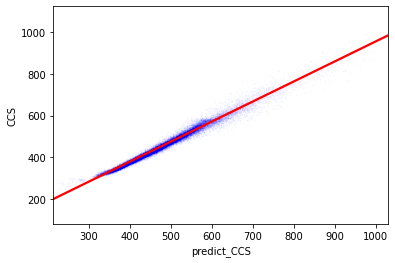

<class 'statsmodels.iolib.summary.Summary'>
"""
                            GLS Regression Results                            
==============================================================================
Dep. Variable:                    CCS   R-squared:                       0.979
Model:                            GLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                 1.933e+06
Date:                Mon, 08 Nov 2021   Prob (F-statistic):               0.00
Time:                        00:06:00   Log-Likelihood:            -1.7057e+05
No. Observations:               42253   AIC:                         3.411e+05
Df Residuals:                   42251   BIC:                         3.412e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                  coef    std err          t      P>|t| [0.025000000000000022      0.975]
-----------------------------------------------------------------------------------------
const          -5.8678      0.339    -17.298      0.000                -6.533      -5.203
predict_CCS     0.9618      0.001   1390.478      0.000                 0.960       0.963
==============================================================================
Omnibus:                     7499.689   Durbin-Watson:                   1.922
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           183626.343
Skew:                           0.102   Prob(JB):                         0.00
Kurtosis:                      13.211   Cond. No.                     2.49e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.49e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [22]:
psm_df = mq_reader.psm_df.groupby(['sequence','mods','mod_sites','nAA','charge'])['CCS'].median().reset_index()
predict_df = alphaccs.predict(psm_df)
evaluate_linear_regression_plot(predict_df, x='predict_CCS',y='CCS')
evaluate_linear_regression(predict_df, x='predict_CCS',y='CCS')

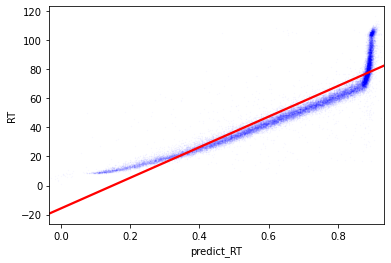

<class 'statsmodels.iolib.summary.Summary'>
"""
                            GLS Regression Results                            
==============================================================================
Dep. Variable:                     RT   R-squared:                       0.869
Model:                            GLS   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                 2.418e+05
Date:                Mon, 08 Nov 2021   Prob (F-statistic):               0.00
Time:                        00:06:25   Log-Likelihood:            -1.3173e+05
No. Observations:               36579   AIC:                         2.635e+05
Df Residuals:                   36577   BIC:                         2.635e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
========================================================================================
                 coef    std err          t      P>|t| [0.025000000000000022      0.975]
----------------------------------------------------------------------------------------
const        -15.6991      0.150   -104.733      0.000               -15.993     -15.405
predict_RT   105.2171      0.214    491.688      0.000               104.798     105.637
==============================================================================
Omnibus:                     8562.316   Durbin-Watson:                   1.904
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            24152.949
Skew:                           1.237   Prob(JB):                         0.00
Kurtosis:                       6.119   Cond. No.                         6.73
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
psm_df = mq_reader.psm_df.groupby(['sequence','mods','mod_sites','nAA'])['RT'].median().reset_index()
predict_df = alphart.predict(psm_df)
evaluate_linear_regression_plot(predict_df, x='predict_RT',y='RT')
evaluate_linear_regression(predict_df, x='predict_RT',y='RT')

# 3. Predicted spectral library

In [29]:
from alphadeep.speclib.predict_lib import PredictLib
predlib = PredictLib(
    pdeep.charged_frag_types, msms_model=pdeep, 
    rt_model=alphart, ccs_model=alphaccs
)
predlib.precursor_df = mq_reader.psm_df

100%|██████████| 41/41 [01:44<00:00,  2.55s/it]


In [25]:
predlib.precursor_df['instrument'] = 'timsTOF'
predlib.precursor_df['NCE'] = 30 # always set as 30 for timsTOF
predlib.load_fragment_inten_df()

100%|██████████| 41/41 [05:21<00:00,  7.84s/it]


In [26]:
predlib.precursor_df

,sequence,charge,RT,CCS,mobility,scan_no,raw_name,score,proteins,genes,nAA,mods,mod_sites,predict_CCS,predict_RT,precursor_mz,frag_start_idx,frag_end_idx,instrument,NCE
0,AFLHANR,2,10.966,309.251928,<NA>,1850,20190107_TIMS2_AnBr_SA_200ng_CElegans_Trp_IRT_...,32.971,A0A2K5ATM0;A0A2K5ATN2;Q18846;Q18846-2,rskn-2,7,,,310.409973,0.171808,414.727386,0,6,timsTOF,0.3
1,ALHFNPR,2,14.713,320.493323,<NA>,2994,20190107_TIMS2_AnBr_SA_200ng_CElegans_Trp_IRT_...,32.971,Q5ZR27;A0A0K3AUS0;H2KZJ9;A0A0K3ASC7,lec-12,7,,,319.006744,0.269358,427.735211,6,12,timsTOF,0.3
2,AYMHIFR,2,16.037,318.701279,<NA>,2524,20190107_TIMS2_AnBr_SA_200ng_CElegans_Trp_IRT_...,42.124,Q9BMU4;Q688Z6;U4PLG5,atln-1,7,Oxidation@M,3,329.013092,0.276184,477.236730,12,18,timsTOF,0.3
3,CDIDIRK,2,12.577,308.752870,<NA>,4107,20190107_TIMS2_AnBr_SA_200ng_CElegans_Trp_IRT_...,61.494,P0DM42;P0DM41;P10984,act-3;act-1;act-2,7,Carbamidomethyl@C,1,321.971100,0.173326,460.236927,18,24,timsTOF,0.3
4,CLEEHLR,2,13.279,316.160175,<NA>,4344,20190107_TIMS2_AnBr_SA_200ng_CElegans_Trp_IRT_...,35.633,G5EFK7;G5EFW2;G5ECP9;G5EEC4;G5ECG8;A0A1N7SYN9;...,vab-10,7,Carbamidomethyl@C,1,334.145447,0.178793,478.734551,24,30,timsTOF,0.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141240,TAPSAIPLAAPALPVPIAAAPFFTPPAPVLAAPAPLLAPPAPVFAAPR,4,108.460,1066.658020,<NA>,53838,20190107_TIMS2_AnBr_SA_200ng_CElegans_Trp_IRT_...,84.529,Q22262,,48,,,978.779297,0.899455,1147.413094,2226826,2226873,timsTOF,0.3
141241,TAPSAIPLAAPALPVPIAAAPFFTPPAPVLAAPAPLLAPPAPVFAAPR,3,108.460,775.979047,<NA>,53839,20190107_TIMS2_AnBr_SA_200ng_CElegans_Trp_IRT_...,115.420,Q22262,,48,,,767.405151,0.899455,1529.548366,2226873,2226920,timsTOF,0.3
141242,TAPSAIPLAAPALPVPIAAAPFFTPPAPVLAAPAPLLAPPAPVFAAPR,3,108.580,781.523487,<NA>,32092,20190107_TIMS2_AnBr_SA_200ng_CElegans_Trp_IRT_...,58.044,Q22262,,48,,,767.405151,0.899455,1529.548366,2226920,2226967,timsTOF,0.3
141243,TAPSAIPLAAPALPVPIAAAPFFTPPAPVLAAPAPLLAPPAPVFAAPR,4,108.520,1086.345571,<NA>,51480,20190107_TIMS2_AnBr_SA_200ng_CElegans_Trp_IRT_...,4.313,Q22262,,48,,,978.779297,0.899455,1147.413094,2226967,2227014,timsTOF,0.3


In [27]:
predlib.fragment_mass_df

,b_1,b_2,y_1,y_2,b_modloss_1,b_modloss_2,y_modloss_1,y_modloss_2
0,72.044390,36.525833,757.410383,379.208829,0.0,0.0,0.0,0.0
1,219.112804,110.060040,610.341969,305.674622,0.0,0.0,0.0,0.0
2,332.196868,166.602072,497.257905,249.132590,0.0,0.0,0.0,0.0
3,469.255780,235.131528,360.198993,180.603134,0.0,0.0,0.0,0.0
4,540.292893,270.650085,289.161879,145.084578,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2227056,3972.276515,1986.641896,561.314357,281.160817,0.0,0.0,0.0,0.0
2227057,4119.344929,2060.176103,414.245943,207.626610,0.0,0.0,0.0,0.0
2227058,4190.382043,2095.694660,343.208829,172.108053,0.0,0.0,0.0,0.0
2227059,4261.419157,2131.213216,272.171716,136.589496,0.0,0.0,0.0,0.0


In [28]:
predlib.fragment_inten_df

,b_1,b_2,y_1,y_2,b_modloss_1,b_modloss_2,y_modloss_1,y_modloss_2
0,0.000000,0.0,350.472666,0.0,0.0,0.0,0.0,0.0
1,172.448549,0.0,4328.272939,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,9954.412580,0.0,0.0,0.0,0.0,0.0
3,21.668512,0.0,8620.934486,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,1006.117985,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2227056,0.000000,0.0,431.936271,0.0,0.0,0.0,0.0,0.0
2227057,0.000000,0.0,305.256825,0.0,0.0,0.0,0.0,0.0
2227058,0.000000,0.0,457.373597,0.0,0.0,0.0,0.0,0.0
2227059,0.000000,0.0,450.107642,0.0,0.0,0.0,0.0,0.0
